## Code to compare the performance of QuakeFlow to conventional catalogs

Goals for this code:

1) Compare picks. For positive matches, calculate mean residual and standard deviation of residuals. Also calculate false positives and false negatives, to yield precision, recall, and F1-score. *TO-DO: decide how to evaluate new picks from PhaseNet that might be correct!

2) TO-DO: Compare association. For earthquakes that match, compare their locations and number of picks and which stations had picks. 

In [17]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load in results from QuakeFlow from a response json file:

In [3]:
load_file = 'result_example'

In [191]:
f = open(load_file+'.json')
result = json.load(f)

catalog_gamma = result["catalog"]
picks_gamma = result["picks"]
print("Catalog:")
display(pd.DataFrame(catalog_gamma)[["time", "latitude", "longitude", "depth(m)", "magnitude", "covariance"]])
print("Association:")
df = pd.DataFrame(picks_gamma)
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
# df['timestamp'] = [obspy.UTCDateTime(t) for t in df['timestamp']]
df.head()

Catalog:


,time,latitude,longitude,depth(m),magnitude,covariance
0,2018-10-01T09:42:15.237,58.17243,-155.232183,13715.249876,1.941594,"2.224,0.391,0.278"


Association:


,id,timestamp,prob,amp,type,event_idx,prob_gmma
0,AV.ACH..BH,2018-10-01T09:42:19.528,0.976541,0.000076,p,0,0.081009
1,AV.ACH..BH,2018-10-01T09:42:20.918,0.930866,0.000076,s,0,0.100742
2,AV.ANCK..BH,2018-10-01T09:42:21.368,0.914994,0.000003,p,0,0.059387
3,AV.ANCK..BH,2018-10-01T09:42:23.798,0.851268,0.000003,s,0,0.069766
4,AV.KABU..BH,2018-10-01T09:42:19.308,0.981695,0.000031,p,0,0.101909


#### Load in the original catalog information:

In [5]:
cat = obspy.core.event.read_events('XO_2018_10.quakeml')

Earthquake on 2018-10-01T09:42:17.906000Z
Earthquake has 26 picks
Earthquake magnitude is 1.4


In [202]:
# All the picks for the month:
picks=[p.picks for p in cat.events]
picks = sum(picks, [])
# All the arrivals for the month:
origins=[p.origins for p in cat.events]
arrivals=[p[0].arrivals for p in origins]
arrivals = sum(arrivals,[])

phase = [p.phase.lower() for p in arrivals]
arr_id = [int(''.join(filter(str.isdigit, str(p.resource_id)))) for p in arrivals]
arr_df = pd.DataFrame({'og_phase':phase,'arr_id':arr_id})

sta_code = [p.waveform_id.network_code+'.'+p.waveform_id.station_code+'..'+p.waveform_id.channel_code[0:2] for p in picks]
channel = [p.waveform_id.channel_code for p in picks]
timestamp = [p.time for p in picks]
pick_id = [int(''.join(filter(str.isdigit, str(p.resource_id)))) for p in picks]
pick_df = pd.DataFrame({'sta_code':sta_code,'pick_id':pick_id,'og_timestamp':timestamp,'og_channel':channel})

# Merge the arrivals and the picks:
ground_truth = pd.merge(left=arr_df, right=pick_df, left_on='arr_id', right_on='pick_id')
# Convert to pandas date-time:
ground_truth['og_timestamp'] = [str(t) for t in ground_truth['og_timestamp']]
ground_truth['og_timestamp']=pd.to_datetime(ground_truth['og_timestamp'],infer_datetime_format=True)


## Let's compare picks between PhaseNet and the original catalog.

#### Now, see which picks are true positives by joining based on phase type, station code, and time residual within a threshold.

In [246]:
resid_max = 1 # seconds

# Let's only compare the part of the original catalog that we have PhaseNet picks for:
cat_start = min(df['timestamp'] - pd.Timedelta(30,'seconds'))
cat_end = max(df['timestamp'] + pd.Timedelta(30,'seconds'))
ground_truth = ground_truth[(ground_truth['og_timestamp'] > cat_start) & (ground_truth['og_timestamp'] < cat_end)]

# Sort both dataframes by time:
df.sort_values(by=['timestamp'],inplace=True)
ground_truth.sort_values(by=['og_timestamp'],inplace=True)

# Merge dataframes, only merging picks if they have matching station ID, 
# phase type, and are within 0.1 s of each other
comp = pd.merge_asof(left=df,right=ground_truth,left_on=['timestamp'],right_on=['og_timestamp'],left_by=['id','type'],right_by=['sta_code','og_phase'],tolerance = pd.Timedelta(resid_max,'seconds'),direction='nearest')

# Add residual column: 
comp['pick_resid'] = comp['og_timestamp'] - comp['timestamp']
comp['pick_resid'] = comp['pick_resid'].dt.total_seconds()

Use the merged dataframe to calculate performance metrics:

In [247]:
true_positives = comp['og_timestamp'].notna().sum()

false_positives = comp['og_timestamp'].isna().sum()

false_negatives = len(ground_truth)-true_positives

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')

There were 20 true positives.
There were 8 false positives.
There were 6 false negatives.
This yields a precision of 0.71, a recall of 0.77, and an F1-score of 0.74.


And residual statistics:

Mean residual was -0.06 seconds.
Residual standard deviation was 0.11 seconds.


<AxesSubplot:>

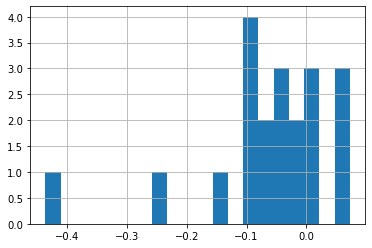

In [250]:
resid = comp['pick_resid'][comp['pick_resid'].notna()]

mean_resid = np.mean(resid)
std_resid = np.std(resid)

print('Mean residual was ' + str(round(mean_resid,2)) + ' seconds.')
print('Residual standard deviation was ' + str(round(std_resid,2)) + ' seconds.')

comp['pick_resid'].hist(bins=20)

In [31]:
resid_max = 0.1

true_positives = len(np.abs(comp['pick_resid'])<=resid_max)
false_positives = len(np.abs(comp['pick_resid'])>resid_max)
cross = pd.merge(left = df, right = ground_truth,how="outer", left_on=['id','type'],right_on=['sta_code','og_phase'])
# Picks that PhaseNet missed:
missed_picks = cross[cross['timestamp'].isna()]
false_negatives = len(missed_picks)

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')


There were 20 true positives.
There were 20 false positives.
There were 6 false negatives.
This yields a precision of 0.5, a recall of 0.77, and an F1-score of 0.61.


## Now let's take a closer look at the "new" picks that PhaseNet got, and see if they look real:



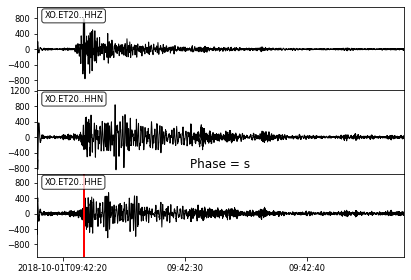

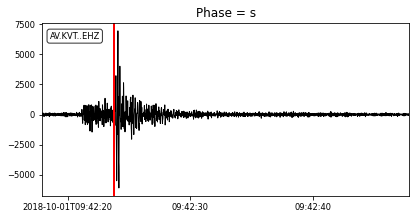

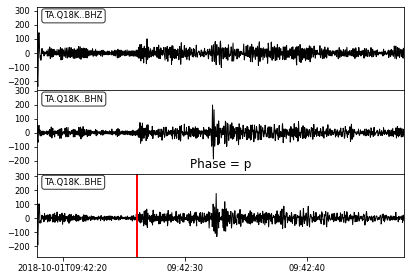

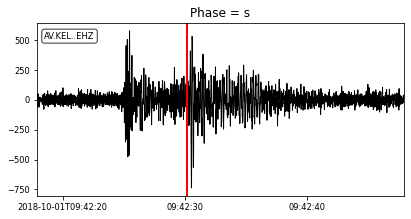

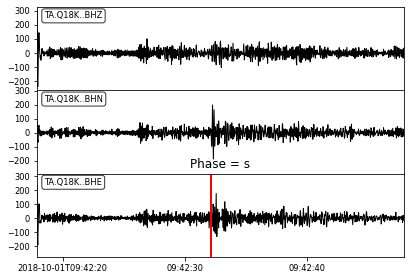

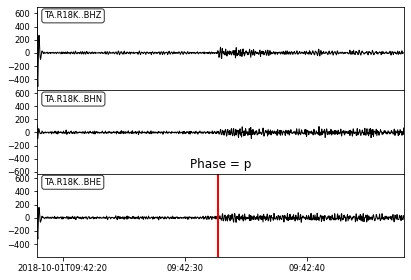

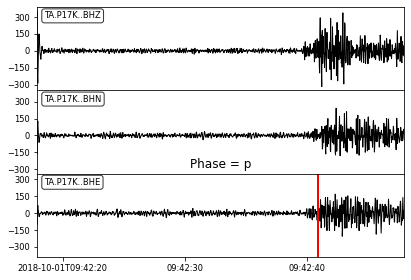

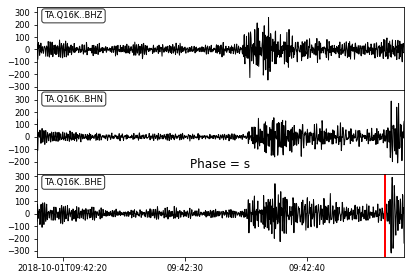

In [251]:
# Picks that PhaseNet got but aren't in the conventional catalog:
new_picks = comp[comp['og_timestamp'].isna()]
new_picks['timestamp'] = [obspy.UTCDateTime(t) for t in new_picks['timestamp']]

client = Client("iris")
interval = 30 #s
starttime = event.origins[0].time
endtime = starttime + interval
stream = obspy.Stream()
for i in range(len(new_picks)):
    txt=new_picks.iloc[i]['id']
    trace_info=txt.split('.')
    # Read in waveform:
    st = client.get_waveforms(trace_info[0],trace_info[1],trace_info[2],trace_info[3]+'*', starttime, endtime,attach_response=True)
    # Do some waveform processing:
    # st.remove_response()
    # st = st.detrend("spline", order=2, dspline=5 * st[0].stats.sampling_rate)
    # st = st.filter("highpass", freq=1.0)
    st = st.filter("bandpass",freqmin=4,freqmax=35)
    
    %matplotlib inline
    fig = plt.figure()
    st.plot(fig = fig,starttime=starttime,endtime=endtime) 
    plt.axvline(x=new_picks.iloc[i]['timestamp'],linewidth=2, color='r')
    plt.title('Phase = '+new_picks.iloc[i]['type'])
    plt.show()




Thoughts:

It is going to be hard to quantify whether these "new" picks are correct or not.

If they associate with an event that is already in the Alaska catalog, maybe we count them as good?

I think it would be good to run an entire month (or week?) of the Alaska data through QuakeFlow.

Then we could get precision, recall, and F1-score, simply to see how well QuakeFlow performed on the already existing picks.

But then it is likely we would get some new picks- how do we evaluate these?

## GOAL 2: evaluate association performance

Start by just looking at the locations of the earthquakes on a map

## TO-DO: plot both on one map

In [260]:
time = [p.origins[0].time for p in cat.events]
lat = [p.origins[0].latitude for p in cat.events]
lon = [p.origins[0].longitude for p in cat.events]
depth = [p.origins[0].depth for p in cat.events]

cat_dict = {"lat":lat,"lon":lon,"depth":depth}

cat_dict = {"lat":lat,"lon":lon,"depth":depth}
cat_df = pd.DataFrame.from_dict(cat_dict)
og_gf = gpd.GeoDataFrame(cat_df.copy(), 
                      geometry=gpd.points_from_xy(cat_df.lon, cat_df.lat),
                      crs=4326)

cat_df = pd.DataFrame.from_dict(catalog_gamma)
gf = gpd.GeoDataFrame(cat_df.copy(),geometry=gpd.points_from_xy(cat_df.longitude, cat_df.latitude),
                      crs=4326)

og_gf.explore()
# gf.explore()

## TO-DO: match up earthquakes based on timing, and for a common event, plot the two different locations but also the different stations that had arrivals - with colors based on true and false positives